# INF200 Lecture No 11

### 22 November 2021

## Today's topics

1. Some advanced Python concepts
    1. Decorators and memoization
    1. Properties
    1. Iterators and generators
1. Generating Data / Scientific Computing
    1. SymPy: Symbolic Algebra with Python
    1. Limits of numerical precision
    1. SciPy: A Scientific Python package

--------

# Some advanced Python concepts


## Decorators and Memoization

- Often useful to equip classes, functions or methods with extra functionality
- Can be wrapped around methods or functions
- Example: print state if debug mode is active
- [Fibonacci numbers](https://en.wikipedia.org/wiki/Fibonacci_number)
$$F_n = F_{n-1}+F_{n-2}\;, F_1 = 1,\; F_2 = 1$$

In [1]:
def fib(n):
    if n < 3:
        return 1
    else:
        return fib(n-1) + fib(n-2)

In [2]:
fib(1), fib(2), fib(3), fib(4), fib(5)

(1, 1, 2, 3, 5)

In [3]:
fib(30)

832040

- Would like to see recursive calls
- Do not want to insert print statements into code
- Wrap printing around functions!

In [4]:
def show_args(*args, **kwargs):
    print(args)
    print(kwargs)

In [5]:
show_args(5)

(5,)
{}


In [6]:
show_args(5, 6, 'a', foo=25, t=10)

(5, 6, 'a')
{'foo': 25, 't': 10}


In [7]:
def show_steps(func):
    
    def wrapped_func(*args, **kwargs):

        print('Args:', *args, kwargs)

        res = func(*args, **kwargs)

        print('Res :', res)

        return res
    
    return wrapped_func

In [8]:
fib = show_steps(fib)

In [9]:
fib(3)

Args: 3 {}
Args: 2 {}
Res : 1
Args: 1 {}
Res : 1
Res : 2


2

- Tidier: Use decorator notation

In [10]:
@show_steps
def fib(n):
    if n < 3:
        return 1
    else:
        return fib(n-1) + fib(n-2)

In [11]:
fib(3)

Args: 3 {}
Args: 2 {}
Res : 1
Args: 1 {}
Res : 1
Res : 2


2

In [12]:
fib(5)

Args: 5 {}
Args: 4 {}
Args: 3 {}
Args: 2 {}
Res : 1
Args: 1 {}
Res : 1
Res : 2
Args: 2 {}
Res : 1
Res : 3
Args: 3 {}
Args: 2 {}
Res : 1
Args: 1 {}
Res : 1
Res : 2
Res : 5


5

### Application: Memoize functions

- `fib()` for large arguments means many repeated calls with same argument
- Eliminate by storing values we have seen before
- Called *memoization*
- Can be implemented using closure

#### "Manual" implementation

In [13]:
def memoize(func):
    _memo = {}

    def wrapped(arg):
        if arg not in _memo:
            _memo[arg] = func(arg)
        return _memo[arg]
    
    return wrapped

**NOTE: Cells below must be executed in order!**

##### Original function, not memoized

In [14]:
def memo_fib(n):
    if n < 3:
        return 1
    else:
        return memo_fib(n-1) + memo_fib(n-2)

In [15]:
memo_fib

<function __main__.memo_fib(n)>

##### Wrap function with memoize, obtain a closure

- Note that we must assign to same name again because of recursion!

In [16]:
memo_fib = memoize(memo_fib)

In [17]:
memo_fib

<function __main__.memoize.<locals>.wrapped(arg)>

##### Test on slightly larger n

In [18]:
memo_fib(35)

9227465

In [19]:
memo_fib(100)

354224848179261915075

In [20]:
memo_fib(200)

280571172992510140037611932413038677189525

In [21]:
float(memo_fib(200))

2.8057117299251016e+41

##### For comparison using a version without memoization

In [22]:
def plain_fib(n):
    if n < 3:
        return 1
    else:
        return plain_fib(n-1) + plain_fib(n-2)

plain_fib(36)

14930352

- Significantly slower!

#### The same using memoize as decorator

In [23]:
@memoize
def fib(n):
    if n < 3:
        return 1
    else:
        return fib(n-1) + fib(n-2)

In [24]:
fib(200)

280571172992510140037611932413038677189525

- Shorter code
- No risk of unexpected results if cells are evaluated out-of-order (in Notebook)

## Properties

- OO Idea 2: Hide implementation details
- E.g., two different `Vector` implementations

```Python
class V:
    def __init__(self, x, y):
        self._c = [x, y]

class W:
    def __init__(self, x, y):
        self._x, self._y = x, y
```

- Problem
    - need accessor methods for coordinates
    - clumsy to use

```Python
    def getX(self): return self._x
    def getY(self): return self._y
    ...
    print v.getX() + v.getY()
```

- Solution: *Properties*
- Make accessor methods easily available
- In practice: 
    - define accessor methods
    - add methods as property to class using the Python `property()` function
- We only look at properties getting information
    - such read-only properties prevent that users change data
    - one can also implement properties that can be set
    - see [Python documentation for `property()`](https://docs.python.org/3.9/library/functions.html?highlight=property#property)

In [25]:
class V:
    def __init__(self, x, y):
        self._c = [x, y]
        
    def __repr__(self):
        return 'W({}, {})'.format(self.x, self.y)

    def getX(self): return self._c[0]
    x = property(getX)

    def getY(self): return self._c[1]
    y = property(getY)

v = V(1, 2)
print(v.x)
print(v.y)
print(v)

1
2
W(1, 2)


In [26]:
v.x = 10

AttributeError: can't set attribute

#### Syntactic sugar: The property decorator

- *Syntactic sugar*: a way to express things "more nicely" without adding a new feature ("same stuff, nice wrapping")
- *Decorator*
    - a special type of function
    - name begins with `@`
    - modifies the definition following the decorator
- `@property` decorator makes it easy to create read-only properties

In [27]:
class V:
    def __init__(self, x, y):
        self._c = [x, y]
    def __repr__(self):
        return 'V({}, {})'.format(self.x, self.y)

    @property
    def x(self): return self._c[0]
    
    @property
    def y(self): return self._c[1]

v = V(1, 2)
print(v.x, v.y)

1 2


In [28]:
v.y = 10

AttributeError: can't set attribute

#### More complex properties

- Can also provide values as properties that require more complex operations
- Example: polar representation of vector

In [29]:
import math

class V:
    def __init__(self, x, y):
        self._c = [x, y]
    def __repr__(self):
        return 'V({}, {})'.format(self.x, self.y)

    @property
    def x(self): 
        return self._c[0]
    
    @property
    def y(self): 
        return self._c[1]
    
    @property
    def r(self): 
        return math.sqrt(self.x**2 + self.y**2)
    
    @property
    def phi(self): 
        return math.atan2(self.x, self.y)

v = V(3, 4)
print(v.r, v.phi)

5.0 0.6435011087932844


#### Lazy evaluation

- Some properties may be expensive to compute
- In example above, if `r` or `phi` are used often, calculation repeated over and over again
- Could compute in constructor, but that costs if `r` and `phi` are never used
- Idea: compute only when needed, then retain
- Need to decide on most useful approach depending on use case

In [30]:
class V:
    def __init__(self, x, y):
        self._c = [x, y]
        self._r = None
        self._phi = None
        
    def __repr__(self):
        return 'V({}, {})'.format(self.x, self.y)

    @property
    def x(self): return self._c[0]
    
    @property
    def y(self): return self._c[1]
    
    @property
    def r(self): 
        if self._r is None:
            self._r = math.sqrt(self._c[0]**2+self._c[1]**2)
        return self._r
    
    @property
    def phi(self): 
        if self._phi is None:
            self._phi = math.atan2(self._c[0], self._c[1])
        return self._phi

v = V(3, 4)
print(v.r, v.phi)

5.0 0.6435011087932844


## Iterators and Generators

- We commonly have data types containing elements that we access in sequence
    - elements of a list, characters of a string, lines in a file, ...
- Occasionally, we wan to generate numbers, permutations, etc, in sequence
    - Fibonacci numbers, card permutations, ...

### Basics

#### [Iterable](https://docs.python.org/3/glossary.html#term-iterable)

Any object that can be iterated over, i.e., and object that has elements or values that can be accessed in sequence.

#### [Iterator](https://docs.python.org/3/glossary.html#term-iterator)

An object that represents a stream of data, i.e., a sequence of elements or values.

##### Note
- In Python, every iterator is also an iterable, but not each iterable is an iterator.
- Example:
    - Each `list` is an iterable, but not an iterator
    - We can have multiple iterators for any given list
- See also
    - http://nvie.com/posts/iterators-vs-generators
    - https://www.python-course.eu/python3_generators.php
    - https://docs.python.org/3/howto/functional.html
    
### Working with iterators

- `iter(a)` provides us with an iterator for an iterable `a`
- `next(i)` returns the next value from the iterator `i`
- `StopIteration` exception is raise when no more values available

#### Example

In [31]:
cities = ['Oslo', 'Bergen', 'Trondheim', 'Tromsø']
c_it = iter(cities)
next(c_it)

'Oslo'

In [32]:
next(c_it)

'Bergen'

In [33]:
c_it_2 = iter(cities)

In [34]:
next(c_it), next(c_it_2)

('Trondheim', 'Oslo')

In [35]:
next(c_it), next(c_it_2)

('Tromsø', 'Bergen')

In [36]:
next(c_it)

StopIteration: 

#### How `for` really works

```python
for n in [11, 22, 33]:
  print(n)
```

1. calls `iter()` on list `[11, 22, 33]`
1. runs `n = next()` on  iterator
1. executes loop body
1. goto 2
1. exits when iterator raises `StopIteration`

### Defining an iterator

- An iterator is a class
- It must provide a `__next__()` method returning items in sequence
- It must provide an `__iter__()` method returning itself (iterators are iterables)
- NB: iterables provide and `__iter__()` method that returns an interator object

#### Example: Fibonacci numbers

In [37]:
class FibsIterator:
    def __init__(self, maxValue):
        self._a, self._b = 0, 1
        self.maxValue = maxValue
    
    def __iter__(self):
        return self
    
    def __next__(self):
        self._a, self._b = self._b, self._a + self._b
        if self._a > self.maxValue:
            raise StopIteration
        return self._a

In [38]:
fi = FibsIterator(5)
fi.__next__(), next(fi), next(fi), next(fi)

(1, 1, 2, 3)

[Code on Python Tutor](http://www.pythontutor.com/visualize.html#code=class%20FibsIter%3A%0A%20%20%20%20def%20__init__%28self,%20maxValue%29%3A%0A%20%20%20%20%20%20%20%20self._a,%20self._b%20%3D%200,%201%0A%20%20%20%20%20%20%20%20self.maxValue%20%3D%20maxValue%0A%20%20%20%20%0A%20%20%20%20def%20__iter__%28self%29%3A%0A%20%20%20%20%20%20%20%20return%20self%0A%20%20%20%20%0A%20%20%20%20def%20__next__%28self%29%3A%0A%20%20%20%20%20%20%20%20self._a,%20self._b%20%3D%20self._b,%20self._a%20%2B%20self._b%0A%20%20%20%20%20%20%20%20if%20self._a%20%3E%20self.maxValue%3A%0A%20%20%20%20%20%20%20%20%20%20%20%20raise%20StopIteration%0A%20%20%20%20%20%20%20%20return%20self._a%0A%20%20%20%20%20%20%20%20%0Afi%20%3D%20FibsIter%285%29%0Afi.__next__%28%29,%20next%28fi%29,%20next%28fi%29,%20next%28fi%29%0A&cumulative=false&curInstr=0&heapPrimitives=false&mode=display&origin=opt-frontend.js&py=3&rawInputLstJSON=%5B%5D&textReferences=false)

In [39]:
print([f for f in FibsIterator(10)])
print([f for f in FibsIterator(100)])

[1, 1, 2, 3, 5, 8]
[1, 1, 2, 3, 5, 8, 13, 21, 34, 55, 89]


In [40]:
sum(f for f in FibsIterator(100))

232

### Generators: Compact iterators

- Writing iterators requires a lot of "boilerplate" (typeskilt) code, i.e., code that is the same for each iterator
- *Generators* are similar to iterators, but Python does most of the work behind the scenes
- We only define a single function
- Using `yield` instead of `return` makes this a generator function

In [41]:
def FibsPrint(maxValue):
    a, b = 1, 1
    while a < maxValue:
        print(a)
        a, b = b, a + b

In [42]:
FibsPrint(10)

1
1
2
3
5
8


In [43]:
def FibsGen(maxValue):
    a, b = 1, 1
    while a < maxValue:
        yield a
        a, b = b, a + b
        
fg = FibsGen(5)
next(fg), next(fg), next(fg), next(fg)

(1, 1, 2, 3)

[Code on PythonTutor](http://www.pythontutor.com/visualize.html#code=def%20FibsGen%28maxValue%29%3A%0A%20%20%20%20a,%20b%20%3D%201,%201%0A%20%20%20%20while%20a%20%3C%20maxValue%3A%0A%20%20%20%20%20%20%20%20yield%20a%0A%20%20%20%20%20%20%20%20a,%20b%20%3D%20b,%20a%20%2B%20b%0A%20%20%20%20%20%20%20%20%0Afg%20%3D%20FibsGen%285%29%0Afg.__next__%28%29,%20next%28fg%29,%20next%28fg%29,%20next%28fg%29&cumulative=false&curInstr=0&heapPrimitives=false&mode=display&origin=opt-frontend.js&py=3&rawInputLstJSON=%5B%5D&textReferences=false)

- `fg` is iterator object with `__next__()` method
- On first call to `__next__()`, code is executed from start of generator function up to and including `yield`
- `yield` returns value and execution stops (just as `return`)
- Generator *remembers* local variable `a`, `b`, `maxValue`
- On *next* and all further calls to `__next__()`, execution starts immediately after `yield` statement
- When execution reaches end of generator function, `StopIteration` is raised

#### Tracking a generator step by step

- We add some output lines to a generator, so we can see exactly what happens

In [44]:
def FibsGenVerbose(maxValue):
    print("Entering")
    a, b = 1, 1
    print("Before while (a={}, b={}, maxValue={})".format(a, b, maxValue))

    while a < maxValue:
        print("Before yield (a={}, b={}, maxValue={})".format(a, b, maxValue))
        yield a
        print("After  yield (a={}, b={}, maxValue={})".format(a, b, maxValue))
        a, b = b, a + b
        print("End    while (a={}, b={}, maxValue={})".format(a, b, maxValue))

    print("End code     (a={}, b={}, maxValue={})".format(a, b, maxValue))

We now create a generator and call its `next()` method several times:

In [45]:
fg = FibsGenVerbose(3)

In [46]:
next(fg)

Entering
Before while (a=1, b=1, maxValue=3)
Before yield (a=1, b=1, maxValue=3)


1

Note that execution ended with `yield`.

In [47]:
next(fg)

After  yield (a=1, b=1, maxValue=3)
End    while (a=1, b=2, maxValue=3)
Before yield (a=1, b=2, maxValue=3)


1

Execution recommenced immediately after `yield` and continued until `yield` was "reached again.

In [48]:
next(fg)

After  yield (a=1, b=2, maxValue=3)
End    while (a=2, b=3, maxValue=3)
Before yield (a=2, b=3, maxValue=3)


2

The same once more. Note that we now have `b == 3`, i.e., we will get `a == 3` on the next call, so the `while`-condition will no longer be fulfilled.

In [49]:
next(fg)

After  yield (a=2, b=3, maxValue=3)
End    while (a=3, b=5, maxValue=3)
End code     (a=3, b=5, maxValue=3)


StopIteration: 

We now left the loop, reached the end of the code, and triggered a `StopIteration` exception.

When we use a generator inside a `for`-loop, the loop will catch this exception and stop:

In [50]:
for n in FibsGenVerbose(3):
    print("***** {} *****".format(n))

Entering
Before while (a=1, b=1, maxValue=3)
Before yield (a=1, b=1, maxValue=3)
***** 1 *****
After  yield (a=1, b=1, maxValue=3)
End    while (a=1, b=2, maxValue=3)
Before yield (a=1, b=2, maxValue=3)
***** 1 *****
After  yield (a=1, b=2, maxValue=3)
End    while (a=2, b=3, maxValue=3)
Before yield (a=2, b=3, maxValue=3)
***** 2 *****
After  yield (a=2, b=3, maxValue=3)
End    while (a=3, b=5, maxValue=3)
End code     (a=3, b=5, maxValue=3)


#### Iterators and Generators are used in just the same way

In [51]:
sum(FibsIterator(100)), sum(FibsGen(100))

(232, 232)

-----------

# Generating data / Scientific Python

- This course provides only a brief introduction to Scientific Python
- See especially [J. R. Johansson's book *Numerical Python*](http://jrjohansson.github.io/numericalpython.html)
    - Available for free as [eBook from NMBU network](https://link.springer.com/book/10.1007/978-1-4842-0553-2)
    - [Jupyter Notebooks for the book on Github](https://github.com/jrjohansson/numerical-python-book-code)
- See also 
    - J.R.Johanssons' [Introduction to Scientific Computing with Python](http://nbviewer.ipython.org/github/jrjohansson/scientific-python-lectures/blob/master/Lecture-0-Scientific-Computing-with-Python.ipynb)
    - [Python Scienctific Lecture Notes](http://scipy-lectures.github.io/) 


## Version information

- When working with scientific Python, we often use a large stack of packages
- Can be useful to freeze a set of package version using a [conda environment](https://conda.io/docs/user-guide/tasks/manage-environments.html)
- Important to keep track of which versions we are using

#### A little tool to display version information

In [52]:
import importlib

def show_versions(additional_modules=None):
    """
    Displays table of version numbers.
    
    :param additional_modules: Iterable with modules beyond default modules
    """

    modules = ['numpy', 'scipy', 'pandas', 'matplotlib']

    if additional_modules:
        modules += additional_modules
        
    for name in modules:
        try:
            mod = importlib.import_module(name)
        except ImportError:
            print(f'{name:12} module not available')
            continue
            
        try:    
            print(f'{name:12} {mod.__version__:8}')
        except AttributeError:
            print(f'{name:12} no version information')

In [53]:
show_versions()

numpy        1.21.2  
scipy        1.7.1   
pandas       1.3.4   
matplotlib   3.4.3   


In [54]:
show_versions(['seaborn', 'sympy', 'sklearn'])

numpy        1.21.2  
scipy        1.7.1   
pandas       1.3.4   
matplotlib   3.4.3   
seaborn      0.11.2  
sympy        1.9     
sklearn      1.0.1   


----------

## A *very* short introduction to SymPy

- [SymPy](http://www.sympy.org/en/index.html) provides *computer algebra* or *symbolic mathematics* in Python
- It allows you to perform *symbolic* manipulations on mathematical expressions (instead of *numerical* calculations)
- Examples based on SymPy documentation

In [55]:
import sympy as sy
sy.init_printing(use_latex=True)

### Simplify expressions

- Before we can use a variable name as a *symbolic* variable, we need to define it as such

In [56]:
x = sy.symbols('x')

- We can then use the symbol in mathematical expressions

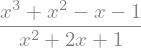

In [57]:
y = (x**3 + x**2 - x - 1)/(x**2 + 2*x + 1)
y

- And we can apply operations, e.g., simplification

In [58]:
sy.simplify(y)

### Find the derivative of an expression

$$\frac{d}{dx} \sin(x) e^x$$

- When using mathematical functions in expressions, we need to take them from SymPy

In [59]:
sy.diff(sy.sin(x) * sy.exp(x), x)

### Find the integral of an expression

$$\int e^x\sin x + e^x \cos x dx$$

In [60]:
sy.integrate(sy.exp(x) * sy.sin(x) + sy.exp(x) * sy.cos(x), x)

### Solve equations

- By default, SymPy assumes that the expression should be zero

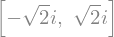

In [61]:
sy.solve(x**2+2, x)

- If the right hand side is not zero, we need to use `Eq`

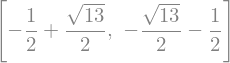

In [62]:
sy.solve(sy.Eq(x**2 + x, 3), x)

- Using `solveset()` we can obtain all solutions

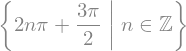

In [63]:
sy.solveset(sy.sin(x)+1, x)

### Some linear algebra

#### Define a matrix

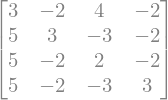

In [64]:
m = sy.Matrix([[3, -2,  4, -2], [5,  3, -3, -2], [5, -2,  2, -2], [5, -2, -3,  3]])
m

#### Matrix-matrix multiplication

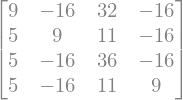

In [65]:
m * m

#### Inverse matrix

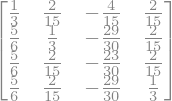

In [66]:
m_inv = m**(-1)
m_inv

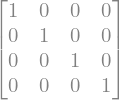

In [67]:
m * m_inv

#### Determinant

In [68]:
m.det()

#### Eigenvalues and eigenvectors

In [69]:
m.eigenvals()

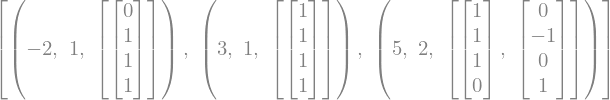

In [70]:
m.eigenvects()

In [71]:
sy.init_printing(use_latex=False)

-------------------------

## Limits of numerical precision

- Computers represent floating point numbers with a fixed number of digits
- Most used today
    - 64-bit floating point numbers (aka "doubles")
    - 53-bit mantissa $\implies$ ca. 16 digits
    - smallest and largest numbers ca. $10^{-308}$ and $10^{308}$
    - details defined in [IEEE754 Standard for Floating-Point Arithmetic](https://en.wikipedia.org/wiki/IEEE_754)
- Machine learning often uses lower precision to gain performance

#### Example

In [72]:
import math

In [73]:
math.exp(math.log(5))

4.999999999999999

The numerical error in this case is

In [74]:
math.exp(math.log(5)) - 5

-8.881784197001252e-16

- This is $-8.8817841970012523\times 10^{-16}$
- Such errors are unavoidable and we need to handle them properly
- *Numerical mathematics* is a branch of mathematics that focuses on how to obtain reliable results efficiently even while working with limited precision

#### Machine precision `eps`

Machine precision is the smallest number for which `1 + x > 1` yields `True`.

In [75]:
x = 1.
while 1 + x > 1:
    x /= 2
print(2 * x)

2.220446049250313e-16


- This is the typical machine precision for 64-bit floating point numbers with 53-bit mantissa.
- It is equal to 

In [76]:
2**-52

2.220446049250313e-16

----------

## SciPy: A package for scientific computing with Python

- Builds on NumPy
- [User Guide](https://scipy.github.io/devdocs/tutorial/index.html#user-guide)
- Components
    - Special functions (scipy.special)
    - Integration (scipy.integrate)
    - Optimization (scipy.optimize)
    - Interpolation (scipy.interpolate)
    - Fourier Transforms (scipy.fft)
    - Signal Processing (scipy.signal)
    - Linear Algebra (scipy.linalg)
    - Sparse eigenvalue problems with ARPACK
    - Compressed Sparse Graph Routines (scipy.sparse.csgraph)
    - Spatial data structures and algorithms (scipy.spatial)
    - Statistics (scipy.stats)
    - Multidimensional image processing (scipy.ndimage)

### SciPy Example: The Lotka-Volterra Model of Population Dynamics

- Classic model of predator-prey population dynamics
- Two species
    - A prey species, e.g., hares
    - A predator species, e.g., foxes
- Each species is represented by a single density variable
- Dynamics are described by coupled, non-linear differential equations
\begin{align}
\dot{x} &= \alpha x - \beta x z  \\
\dot{z} &= \delta x z - \gamma z 
\end{align}
where $x$ is prey and $z$ is predator.
- Notes:
    - Solutions are continuous functions
    - Fractional values for $x$ and $z$ are possible, and animals never become extinct
    - One can remove three out of the four parameters by re-scaling
- See also [Wikipedia](https://en.wikipedia.org/wiki/Lotka–Volterra_equations)

#### Implementation considerations

- SciPy supports integration of ODEs of the form
$$
\vec{y}'(t) = \frac{d\vec{y}}{dt} = f(\vec{y}, t; \text{parameters})
$$
- This function gives the *instantaneous change*
- $\vec{y}$ is the *state vector* describing the system
- We need to combine all variables describing our system into the state vector
$$\vec{y}=\begin{bmatrix}x \\ z\end{bmatrix}$$
- The simplest way to solve the equations is the [forward Euler method](https://en.wikipedia.org/wiki/Euler_method)
$$\vec{y}(t_{k+1}) = \vec{y}(t_k) + \Delta \times \vec{y}'(t_k)\quad\text{with}\quad \Delta = t_{k+1}-t_k\;.$$
- SciPy's `odeint` provides a more advanced way to solve the equations (better accuracy)
- Note that you must import `scipy.integrate`

In [77]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.integrate

In [78]:
plt.rcParams['figure.figsize'] = (12, 4)

- Define derivative function
    - Our function does not use parameter `t`, the time at which we evaluate the derivative, because time does not appear expliclity in the differetial equations
    - If we want to include, e.g., seasonal variation, we could add a term depending explicitly on `t`

In [79]:
def lv_dynamics(y, t, alpha, beta, gamma, delta):
    x, z = y
    dx = alpha * x - beta * x * z
    dz = delta * x * z - gamma * z
    return np.array([dx, dz])

- Create a time axis
- Then call `odeint` to solve the equation system for the given times
- We need to pass as arguments
    - The function computing the derivatives
    - The initial conditions $\vec{y}(0) = \left(x(0), z(0)\right)$
    - The time axis
    - The parameters for the derivatives function

In [80]:
t = np.linspace(0, 15, num=100)
y = scipy.integrate.odeint(lv_dynamics, (10, 5), t, args=(1.0, 0.1, 1.5, 0.075))

- `y` now has two columns, one with the values for `x`, one with the values for `z`
- `y` has one row per time step in `t`

In [81]:
print(len(t))
print(y.shape)
print(y[:5, :])

100
(100, 2)
[[10.          5.        ]
 [10.83069053  4.48339944]
 [11.81388408  4.06178257]
 [12.96046926  3.72457292]
 [14.28279236  3.46356423]]


- We now plot

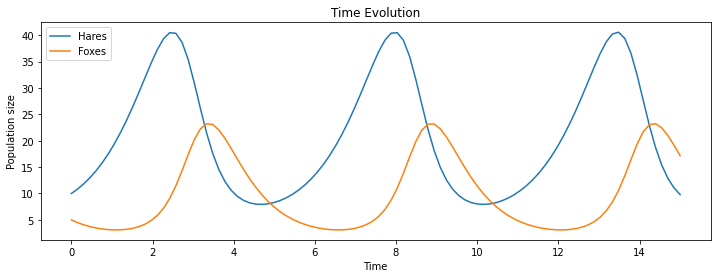

In [82]:
plt.plot(t, y)
plt.legend(['Hares', 'Foxes'], loc='upper left')
plt.title('Time Evolution')
plt.xlabel('Time')
plt.ylabel('Population size');

- We can also look at the number of foxes as a function of the number of hares

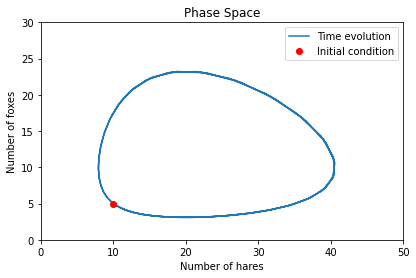

In [83]:
hares, foxes = y[:, 0], y[:, 1]

plt.plot(hares, foxes)
plt.title('Phase Space')
plt.xlabel('Number of hares')
plt.ylabel('Number of foxes')
plt.axis([0, 50, 0, 30])
plt.plot(10, 5, 'ro')
plt.gca().set_aspect(aspect='equal')
plt.legend(['Time evolution', 'Initial condition']);

### How does the minimum number of hares depend on parameters?

In [84]:
alpha = np.linspace(0.5, 1.5, num=20)
beta = np.linspace(0.05, 0.15, num=15)
min_hares = np.zeros((len(alpha), len(beta)))

for aix, a in enumerate(alpha):
    for bix, b in enumerate(beta):
        t = np.linspace(0, 15, num=200)
        y = scipy.integrate.odeint(lv_dynamics, (10, 5), t, args=(a, b, 1.5, 0.075))
        min_hares[aix, bix] = y[:, 0].min()

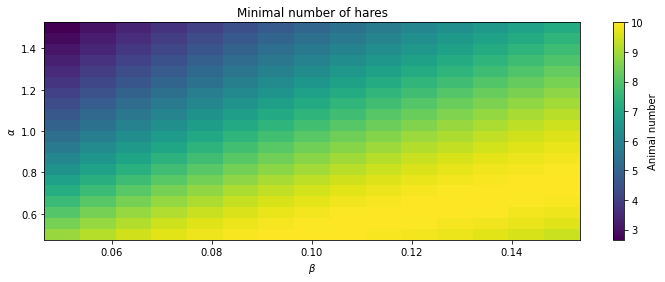

In [85]:
plt.pcolormesh(beta, alpha, min_hares, shading='nearest');
plt.xlabel(r'$\beta$');
plt.ylabel(r'$\alpha$');
plt.title('Minimal number of hares');
cb = plt.colorbar();
cb.ax.set_ylabel('Animal number');

#### Analysis

- This figure is somewhat confusing:
    - Large $\alpha$ means high birth-rate for hares
    - Small $\beta$ means low rate of hares being eaten by foxes
    - Why do we then have the smallest minimum of hares in the top-left corner, where $\alpha$ is largest and $\beta$ is smallest?
- We need to check if this is plausible
    - Plot trajectories for different $(\alpha, \beta)$ combinations


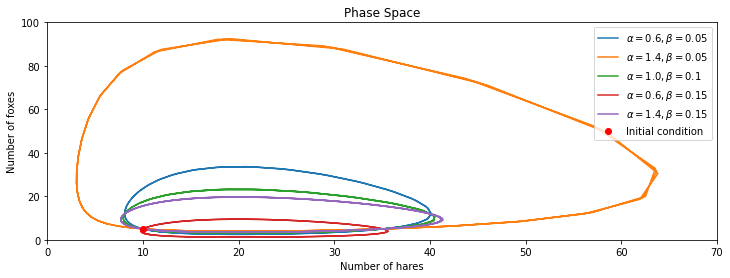

In [90]:
t = np.linspace(0, 15, num=100)
ab_combis = ((0.6, 0.05), (1.4, 0.05), (1.0, 0.1), (0.6, 0.15), (1.4, 0.15))
for alpha, beta in ab_combis:
    y = scipy.integrate.odeint(lv_dynamics, (10, 5), t, args=(alpha, beta, 1.5, 0.075))
    plt.plot(y[:, 0], y[:, 1], label=rf'$\alpha={alpha}, \beta={beta}$')
    
plt.title('Phase Space')
plt.xlabel('Number of hares')
plt.ylabel('Number of foxes')
plt.axis([0, 70, 0, 100])
plt.plot(10, 5, 'ro', label='Initial condition')
#plt.gca().set_aspect(aspect='equal')
plt.legend();

- This plot shows that for the point corresponding to $\alpha=1.4$, $\beta=0.05$ (orange) has the smallest minimal number of hares, but at the same time the largest maximum number as well. So the results seem to make sense.
- We note that the orange curve has some "kinks", which points to a too low time resolution. We thus run the integration again with ten-fold time resolution.

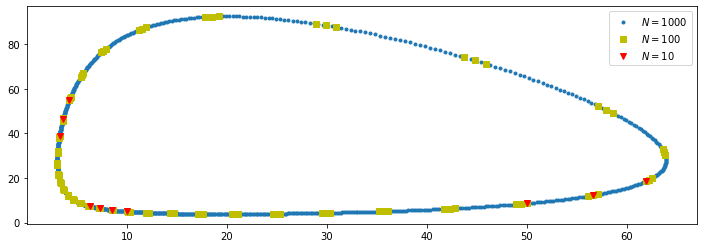

In [109]:
alpha, beta = 1.4, 0.05

for num_timesteps, ls in [(1000, '.'), (100, 'sy'), (10, 'vr')]:
    t = np.linspace(0, 15, num=num_timesteps)
    y = scipy.integrate.odeint(lv_dynamics, (10, 5), t, args=(alpha, beta, 1.5, 0.075))
    plt.plot(y[:, 0], y[:, 1], ls, label=rf'$N = {num_timesteps}$')
plt.legend();

- We see that the points for all resolutions lie on the same curve, but for few points we sample the complete trajectory only very coarsly
- We get this high precision even for low time resolution because `odeint()` uses an advanced adaptive-stepsize solver behind the scenes
- The data points for 10 and 100 time points occur in groups because we integrate up to $t=15$, corresponding to slightly more than three periods of the oscillatory cycle, as seen in the time plot:

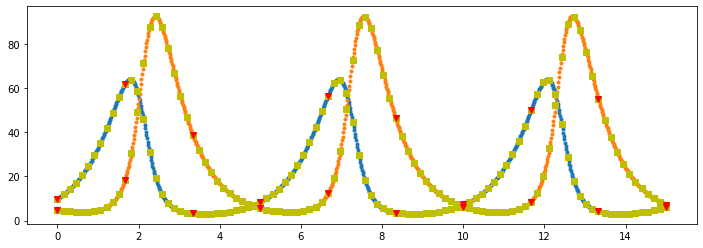

In [113]:
alpha, beta = 1.4, 0.05

for num_timesteps, ls in [(1000, '.'), (100, 'sy'), (10, 'vr')]:
    t = np.linspace(0, 15, num=num_timesteps)
    y = scipy.integrate.odeint(lv_dynamics, (10, 5), t, args=(alpha, beta, 1.5, 0.075))
    plt.plot(t, y, ls)

#### Add-on: Showing the derivatives in the phase plane

- It can be interesing to visualised the right-hand side of the differential equation
- The followin code computes the derivative at certain points in the Hares-Foxes plain and displays it as arrows
- We use a quiver-plot for that

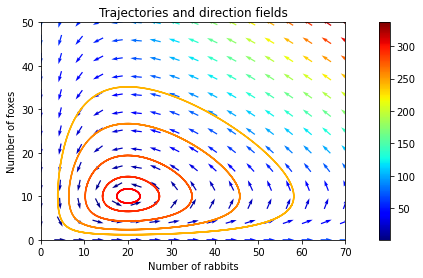

In [117]:
# Plot trajectories
values = ((6, 3), (9, 4), (12, 6), (15, 8), (18, 9))
colors = plt.cm.autumn_r(np.linspace(0.3, 1., len(values)))

for u0, col in zip(values, colors):
    y = scipy.integrate.odeint(lv_dynamics, u0, t, args=(1.0, 0.1, 1.5, 0.075))
    plt.plot(y[:,0], y[:,1], color=col)

# Plot phase space direction arrows
x = np.linspace(0, 70, 17)
y = np.linspace(0, 50, 13)
X, Y = np.meshgrid(x, y)
DX, DY = lv_dynamics([X, Y], 0, 1.0, 0.1, 1.5, 0.075)

# Normalize direction vectors
M = np.hypot(DX, DY)
M[M == 0] = 1.                                 # Avoid zero division errors
DX /= M                                        # Normalize each arrow
DY /= M

plt.title('Trajectories and direction fields')
plt.quiver(X, Y, DX, DY, M, pivot='mid', cmap=plt.cm.jet)
plt.xlabel('Number of rabbits')
plt.ylabel('Number of foxes')
plt.gca().set_aspect(aspect='equal')
plt.axis([0, 70, 0, 50]);
plt.colorbar();